In [23]:
import sys
sys.path.append("/home/kpintaric/LUMEN-Data-Science-IRMAS/")

import torch
import torch.nn as nn
from dataset import IRMASDataset
from utils import get_wav_files, CLASSES
from transforms import PreprocessPipeline, RandomCombine, LabelsFromTxt, OneHotEncode, ParentMultilabel, PreprocessPipelineRNN
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchvision.transforms
import IPython.display as ipd
from torch.nn.utils.rnn import pad_sequence



import matplotlib.pyplot as plt
import numpy as np

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


In [3]:
model = RNN(input_size=128, hidden_size=64, num_layers=3, num_classes=len(CLASSES))

In [4]:
model

RNN(
  (lstm): LSTM(128, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=11, bias=True)
)

In [5]:
preprocess = PreprocessPipelineRNN(target_sr=22050)
transforms = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2560, hop_length=512),
    torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)
])
target_transforms = torchvision.transforms.Compose([
    ParentMultilabel(sep=" "),
    OneHotEncode(CLASSES)
])

data_dir = "/home/kpintaric/LUMEN-Data-Science-IRMAS/data/Dataset/IRMAS_Training_Data"
train_dst = IRMASDataset(data_dir, preprocess=preprocess, transforms=transforms, target_transforms=target_transforms)
sample, label = train_dst[0]

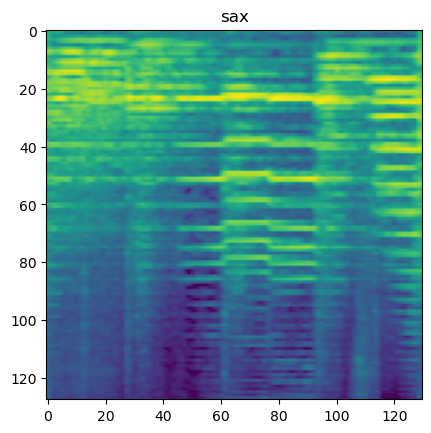

In [6]:
plt.imshow(sample.squeeze())
plt.title(np.array(CLASSES)[label==1][0]);

## Batching variable length data

In [17]:
preprocess = PreprocessPipelineRNN(target_sr=22050)
transforms = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2560, hop_length=512),
    torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)
])
target_transforms = torchvision.transforms.Compose([
    LabelsFromTxt(),
    OneHotEncode(CLASSES)
])

data_dir = "/home/kpintaric/LUMEN-Data-Science-IRMAS/data/Dataset/IRMAS_Validation_Data"
valid_dst = IRMASDataset(data_dir, preprocess=preprocess, transforms=transforms, target_transforms=target_transforms)
sample, label = train_dst[0]

In [21]:
dls = DataLoader(valid_dst, batch_size=8)

In [22]:
next(iter(dls))

RuntimeError: stack expects each tensor to be equal size, but got [1, 128, 246] at entry 0 and [1, 128, 862] at entry 1

In [57]:
def collate_fn(data):

    features, labels = zip(*data)
    features = [item.squeeze().T for item in features]
    features = pad_sequence(features, batch_first=True)
    labels = torch.stack(labels)

    return features, labels

In [58]:
dls = DataLoader(valid_dst, batch_size=8, collate_fn=collate_fn)

In [59]:
one_batch = next(iter(dls))
one_batch[0].shape

torch.Size([8, 862, 128])

In [56]:
preds = model(one_batch[0])
criterion = nn.CrossEntropyLoss()
loss = criterion(preds, one_batch[1])
loss

tensor(4.1966, grad_fn=<DivBackward1>)